In [1]:
# %matplotlib notebook

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

from scipy.integrate import odeint
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec

In [57]:
#Elimates the left and top lines and ticks in a matplotlib plot 
def PlotStyle(Axes,Title):
    
    Axes.spines['top'].set_visible(False)
    Axes.spines['right'].set_visible(False)
    Axes.spines['bottom'].set_visible(True)
    Axes.spines['left'].set_visible(True)
    Axes.set_title(Title)

## Model 1: Radioactive Decay

#### Solving the ODE system given parameters

$\frac{dC}{dt} = -kC$

In [58]:
#Initial Conditions
kc = 2 #Radioactive decay constant
C0 = 1 #Initial amount of radioactive material

In [59]:
#Numpy array that contains the integration times 
SolverTime=np.linspace(0,2)

def ODE(C,t):
    
    return -kc*C

#Solution of the model 
ModelSolution=odeint(ODE,C0,SolverTime)

Text(0, 0.5, 'Amount')

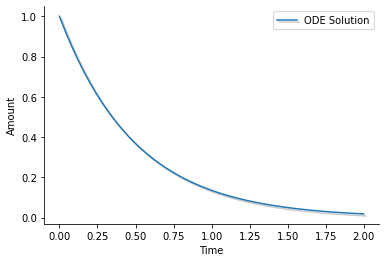

In [60]:
plt.figure(1)
plt.plot(SolverTime,ModelSolution,label='ODE Solution',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
ax=plt.gca()
ax.legend(loc=0)
PlotStyle(ax,'')
plt.xlabel("Time")
plt.ylabel("Amount")

In [61]:
ModelSolution[:,0].shape

(50,)

In [62]:
#General function to solve the ODE model
def GeneralSolver(t,k,C0):
    
    localK = k
    localC0 = C0
    
    def ODEModel(C,t):
        return -localK*C
    sol= odeint(ODEModel,localC0,t)
    return sol[:,0]
    

In [63]:
# GeneralSolver(SolverTime,2,1) #returns the same as above

#### Parameter Estimation

In [64]:
#Solves the ODE model using the initial condition provided above
def ODESolution(t,k):
    return GeneralSolver(t,k,C0)

#Element-wise sum of two iterables of the same size, name makes reference to the output rather than the process
def MakeNoisyData(Data,Noise):
    return [val+cal for val,cal in zip(Data,Noise)]

#Solving the ODE model
t_vals = np.linspace(0,2,num=1000)
solution = ODESolution(t_vals,kc)

#Making some simulated data to perform regression
WhiteNoise =[np.random.uniform(low=-1,high=1)/20 for val in solution]
WhiteSignal = MakeNoisyData(solution,WhiteNoise)

In [65]:
Kp = curve_fit(ODESolution,t_vals,WhiteSignal)
print("Estimated k = {}, estimated standard deviation = {}".format(Kp[0],np.sqrt(Kp[1][0])))

Estimated k = [2.00646502], estimated standard deviation = [0.00734934]


In [66]:
Kp[0]

array([2.00646502])

In [32]:
#Plot the fitted solution
fitSolution=ODESolution(t_vals,Kp[0][0])

Text(0, 0.5, 'Amount')

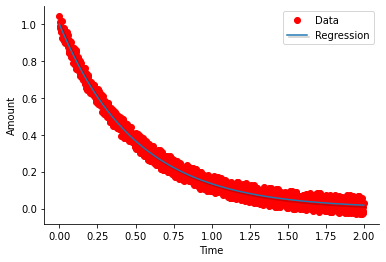

In [33]:
plt.figure(2)

plt.plot(t_vals,WhiteSignal,'ro',label='Data')
plt.plot(t_vals,fitSolution,label='Regression',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
ax=plt.gca()
ax.legend(loc=0)
PlotStyle(ax,'')
plt.xlabel("Time")
plt.ylabel("Amount")

#### Data size and parameter estimation error

In [34]:
#Evaluate impact of data acquisition by changing the number of data points that we generate

In [118]:
#Data size lengths to test
nums = [1000,500,100,50,25,10,5,2]

#Library of ODE solutions
t_lib = [np.linspace(0,2,num=val) for val in nums]
sol_lib = [ODESolution(times,kc) for times in t_lib]

#Library of simulated data
noises = [[np.random.uniform(low=-1,high=1)/20 for val in sol]   for sol in sol_lib]
signal = [MakeNoisyData(sol,noise) for sol,noise in zip(sol_lib,noises)]

#Parameter estimation and performance evaluation
params_and_sds = [curve_fit(ODESolution,times,signals) for times,signals in zip(t_lib,signal)]
params =  [item[0] for item in params_and_sds]
param_sds = [item[1] for item in params_and_sds] 
solutions=[ODESolution(times,ks) for times,ks in zip(t_lib,params)]

#Remember, we set kc as a global variable above
paramError = [100*abs(val-kc)/kc for val in params]


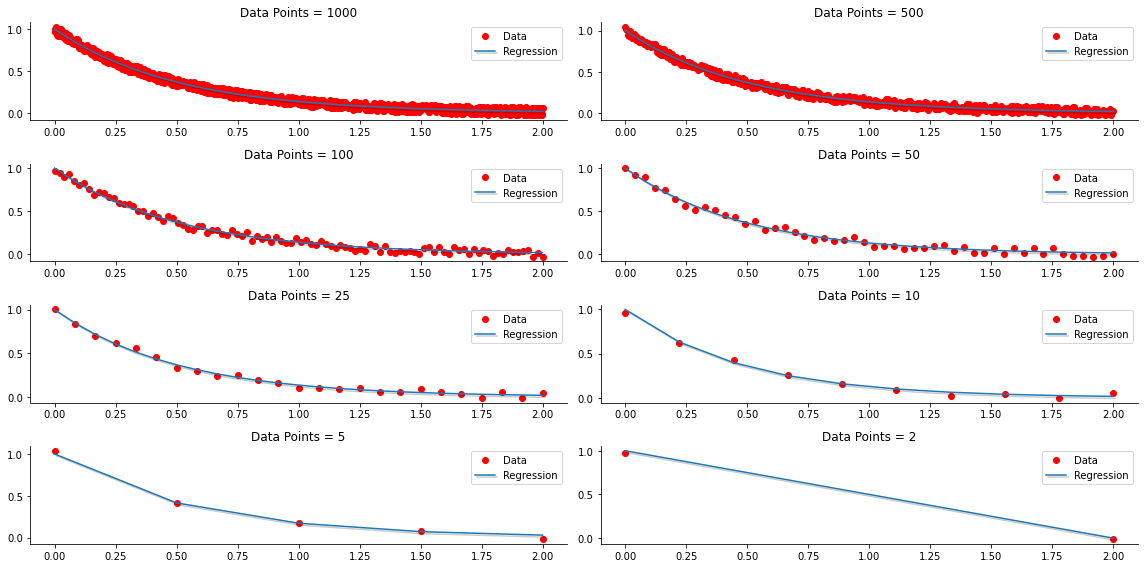

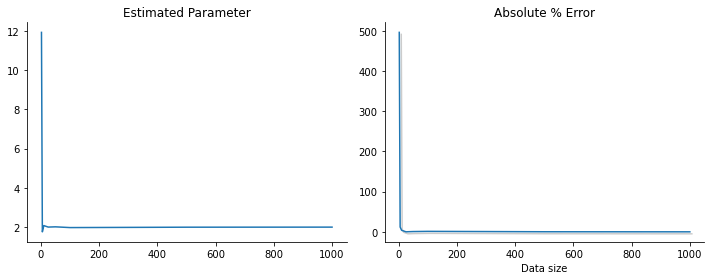

In [122]:
#Data size impact visualization

axs=[(i,j) for i in range(4) for j in range(2)]
fig0,axes = plt.subplots(4,2,figsize=(16,8))

for k in range(len(nums)):
    
    axes[axs[k]].plot(t_lib[k],signal[k],'or',label='Data')
    axes[axs[k]].plot(t_lib[k],solutions[k],label='Regression',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
    axes[axs[k]].legend(loc=0)
    
    title='Data Points = ' + str(len(signal[k]))
    
    PlotStyle(axes[axs[k]],title)
    
plt.tight_layout()

fig1,axs=plt.subplots(1,2,figsize=(10,4))

axs[0].plot(nums,params)
PlotStyle(axs[0],'Estimated Parameter')


axs[1].plot(nums,paramError,path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
axs[1].set_xlabel("Data size")
PlotStyle(axs[1],'Absolute % Error')

plt.tight_layout()

In [126]:
paramError  #nums = [1000,500,100,50,25,10,5,2]

[array([0.02948157]),
 array([0.20688849]),
 array([1.18258829]),
 array([0.712885]),
 array([0.09600381]),
 array([3.88341066]),
 array([12.00295318]),
 array([495.9036206])]

Text(0, 0.5, '% Absolute error')

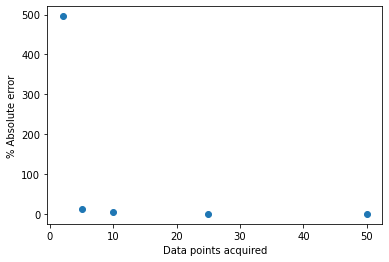

In [144]:
plt.scatter(nums[3:],paramError[3:])
plt.xlabel("Data points acquired")
plt.ylabel("% Absolute error")

#### Residual Analysis

In [139]:
#Data Generation for residual analysis
#ODE solution 
t_data=np.linspace(0,2,50)
sol=ODESolution(t_data,kc)

#Generating noise data with mixed signals 
WhiteNoise=[np.random.uniform(low=-1,high=1)/20 for val in sol]
PeriodicNoise=[np.random.uniform(low=-1,high=1)/30+np.sin(val/np.pi)/30 for val in range(len(t_data))]
LinearNoise=[np.random.uniform(low=-1,high=1)/30-0.04*(val/30) for val in range(len(t_data))]

In [140]:
#Residual Analysis
WhiteSignal=MakeNoisyData(sol,WhiteNoise)
PeriodicSignal=MakeNoisyData(sol,PeriodicNoise)
LinearSignal=MakeNoisyData(sol,LinearNoise)

paramWhite=curve_fit(ODESolution,t_data,WhiteSignal)
paramPeriodic=curve_fit(ODESolution,t_data,PeriodicSignal)
paramLinear=curve_fit(ODESolution,t_data,LinearSignal)

fitSolutionWhite=ODESolution(t_data,paramWhite[0][0])
fitSolutionPeriodic=ODESolution(t_data,paramPeriodic[0][0])
fitSolutionLinear=ODESolution(t_data,paramLinear[0][0])

residualsWhite=[val-cal for val,cal in zip(WhiteSignal,fitSolutionWhite)]
residualsPeriodic=[val-cal for val,cal in zip(PeriodicSignal,fitSolutionPeriodic)]
residualsLinear=[val-cal for val,cal in zip(LinearSignal,fitSolutionLinear)]

In [141]:
#Residual Analysis Visualization

def ResidualsPlot(Figure,Time,Signal,FitSolution,Residuals,Noise):
    
    cFig=Figure
    gridSp=GridSpec(2,2)
    
    ax1=cFig.add_subplot(gridSp[:,0])
    ax2=cFig.add_subplot(gridSp[0,1])
    ax3=cFig.add_subplot(gridSp[1,1])
    
    ax1.plot(Time,Signal,'ro',label='Data')
    ax1.plot(Time,FitSolution,label='Regression',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
    ax1.legend(loc=0)
    PlotStyle(ax1,'Fitted Model')
    
    ax2.plot(Residuals,path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
    PlotStyle(ax2,'Residuals')
    
    ax3.plot(Noise,path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
    PlotStyle(ax3,'Noise')
    
    plt.tight_layout()

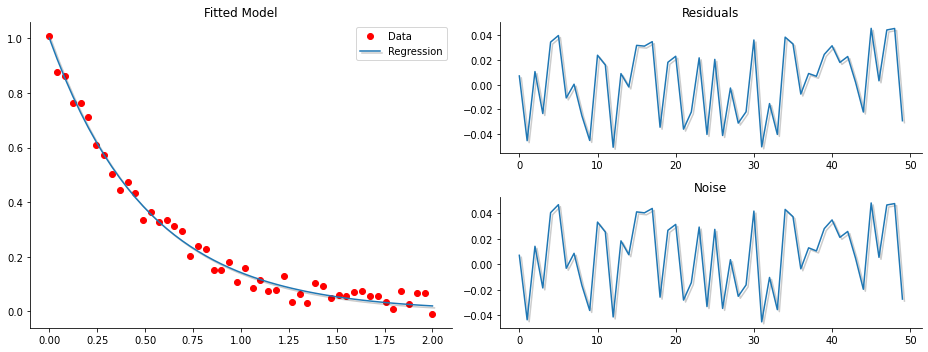

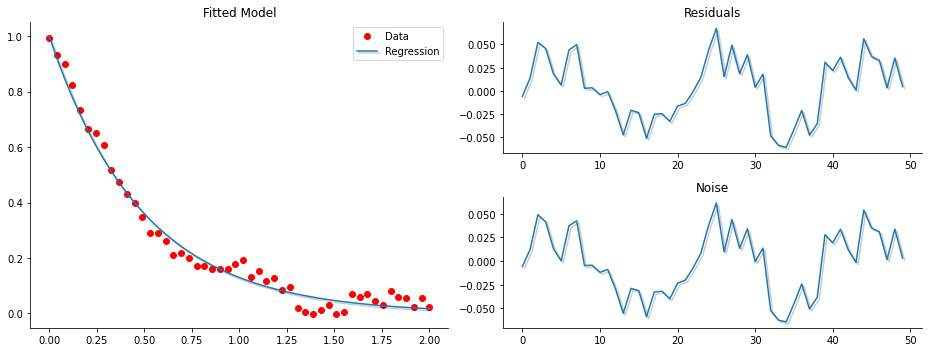

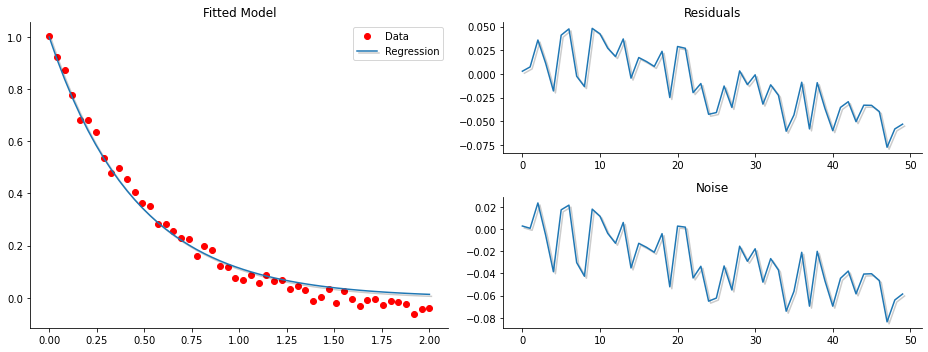

In [142]:
fig2=plt.figure(5,figsize=(13,5))

ResidualsPlot(fig2,t_data,WhiteSignal,fitSolutionWhite,residualsWhite,WhiteNoise)

fig3=plt.figure(6,figsize=(13,5))

ResidualsPlot(fig3,t_data,PeriodicSignal,fitSolutionPeriodic,residualsPeriodic,PeriodicNoise)

fig4=plt.figure(7,figsize=(13,5))

ResidualsPlot(fig4,t_data,LinearSignal,fitSolutionLinear,residualsLinear,LinearNoise)

In [145]:
#Thought: residual patterns might not be apparent when we have a low number of data points